Stock Price Prediction using Machine Learning in Python

Machine learning proves immensely helpful in many industries in automating tasks that earlier required human labor one such application of ML is predicting whether a particular trade will be profitable or not.

In this article, we will learn how to predict a signal that indicates whether buying a particular stock will be helpful or not by using ML.

Let's start by importing some libraries which will be used for various purposes which will be explained later in this article.

Importing Libraries

Python libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.

Pandas - This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.
Numpy - Numpy arrays are very fast and can perform large computations in a very short time.
Matplotlib/Seaborn - This library is used to draw visualizations.
Sklearn - This module contains multiple libraries having pre-implemented functions to perform tasks from data preprocessing to model development and evaluation.
XGBoost - This contains the eXtreme Gradient Boosting machine learning algorithm which is one of the algorithms which helps us to achieve high accuracy on predictions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Importing Dataset
The dataset we will use here to perform the analysis and build a predictive model is Tesla Stock Price data. We will use OHLC('Open', 'High', 'Low', 'Close') data from 1st January 2010 to 31st December 2017 which is for 8 years for the Tesla stocks.

In [ ]:
df = pd.read_csv('/content/Tesla.csv')
df.head()

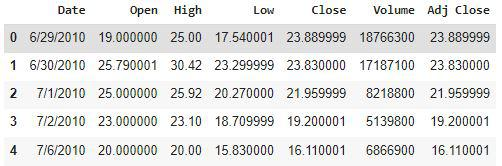

From the first five rows, we can see that data for some of the dates is missing the reason for that is on weekends and holidays Stock Market remains closed hence no trading happens on these days.


df.shape

In [ ]:
df.shape

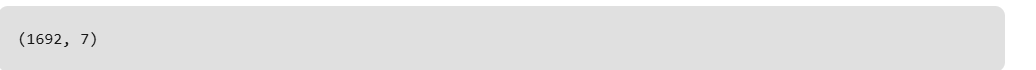

From this, we got to know that there are 1692 rows of data available and for each row, we have 7 different features or columns.

In [ ]:
df.describe()

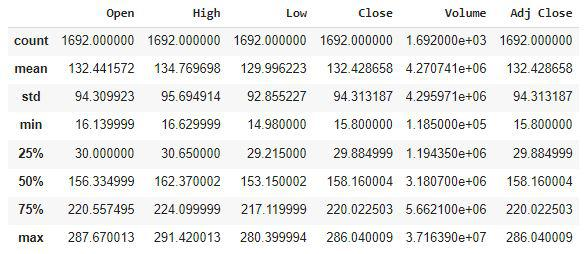

In [ ]:
df.info()

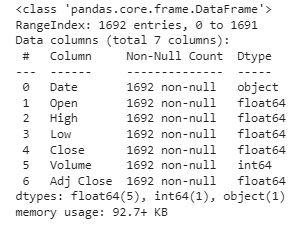

Exploratory Data Analysis
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations.

While performing the EDA of the Tesla Stock Price data we will analyze how prices of the stock have moved over the period of time and how the end of the quarters affects the prices of the stock.

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

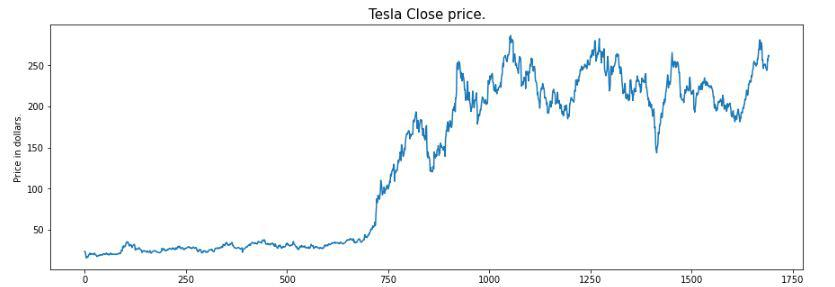

If we observe carefully we can see that the data in the 'Close' column and that available in the 'Adj Close' column is the same let's check whether this is the case with each row or not.

In [ ]:
df[df['Close'] == df['Adj Close']].shape

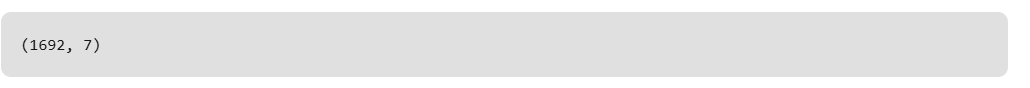

From here we can conclude that all the rows of columns 'Close' and 'Adj Close' have the same data. So, having redundant data in the dataset is not going to help so, we'll drop this column before further analysis.

In [ ]:
df = df.drop(['Adj Close'], axis=1)

Now let's draw the distribution plot for the continuous features given in the dataset.

Before moving further let's check for the null values if any are present in the data frame.

In [ ]:
df.isnull().sum()

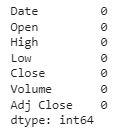

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

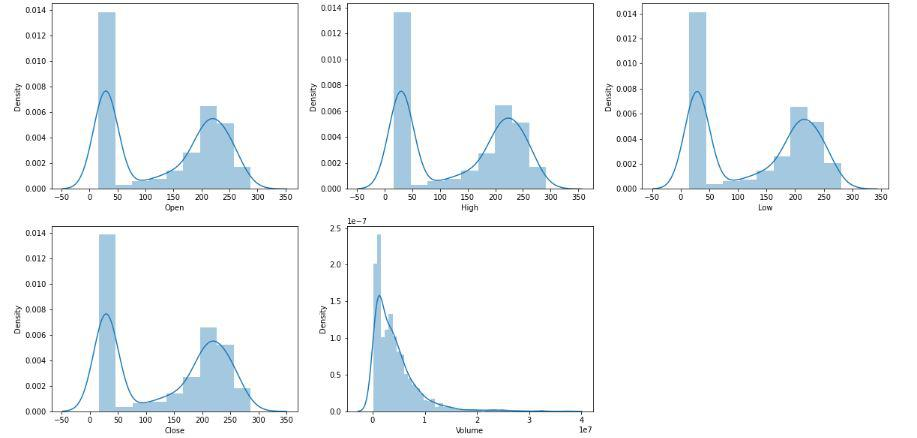

In the distribution plot of OHLC data, we can see two peaks which means the data has varied significantly in two regions. And the Volume data is left-skewed.

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

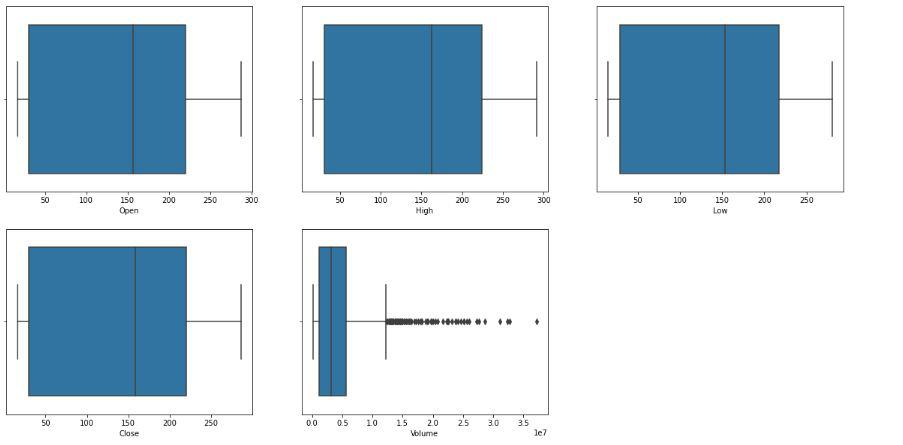

From the above boxplots, we can conclude that only volume data contains outliers in it but the data in the rest of the columns are free from any outlier.

Feature Engineering
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [ ]:
splitted = df['Date'].str.split('/', expand=True)

df['day'] = splitted[1].astype('int')
df['month'] = splitted[0].astype('int')
df['year'] = splitted[2].astype('int')

df.head()

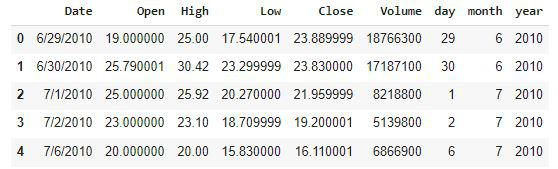

Now we have three more columns namely 'day', 'month' and 'year' all these three have been derived from the 'Date' column which was initially provided in the data.

In [ ]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

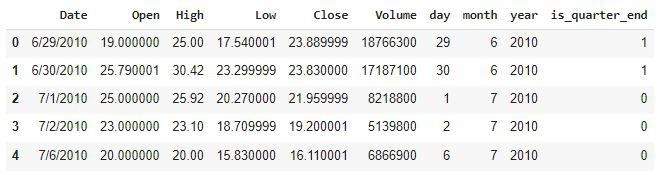

A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company's performance. These quarterly results affect the stock prices heavily which is why we have added this feature because this can be a helpful feature for the learning model.

In [ ]:
data_grouped = df.drop('Date', axis=1).groupby('year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

# This code is modified by Susobhan Akhuli

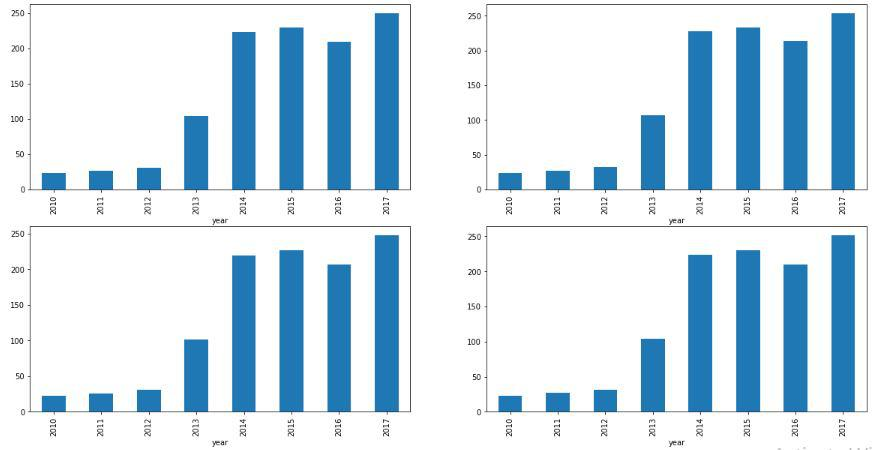

From the above bar graph, we can conclude that the stock prices have doubled from the year 2013 to that in 2014.

In [ ]:
df.drop('Date', axis=1).groupby('is_quarter_end').mean()

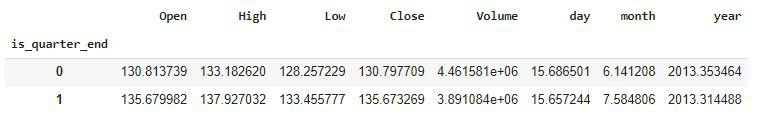

Here are some of the important observations of the above-grouped data:

Prices are higher in the months which are quarter end as compared to that of the non-quarter end months.
The volume of trades is lower in the months which are quarter end.

In [ ]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let's check whether the target is balanced or not using a pie chart.

In [ ]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

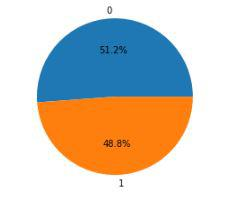

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

In [ ]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

# This code is modified by Susobhan Akhuli

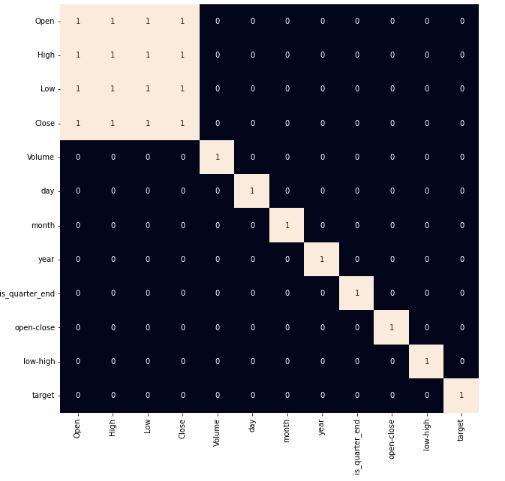

From the above heatmap, we can say that there is a high correlation between OHLC that is pretty obvious, and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.

Data Splitting and Normalization

In [ ]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

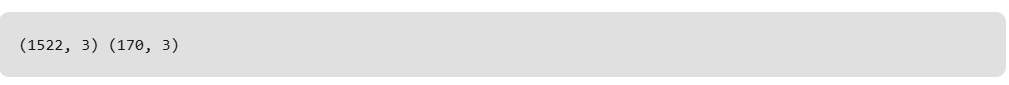

After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

Model Development and Evaluation
Now is the time to train some state-of-the-art machine learning models(Logistic Regression, Support Vector Machine, XGBClassifier), and then based on their performance on the training and validation data we will choose which ML model is serving the purpose at hand better.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [ ]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

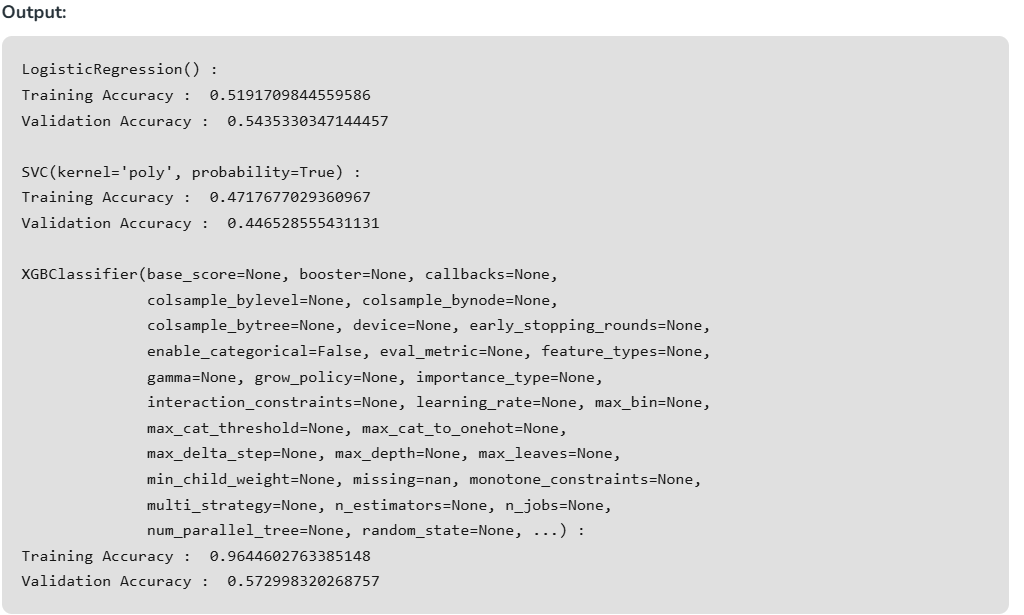

Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high. But in the case of the Logistic Regression, this is not the case.

Now let's plot a confusion matrix for the validation data.

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()

# This code is modified by Susobhan Akhuli

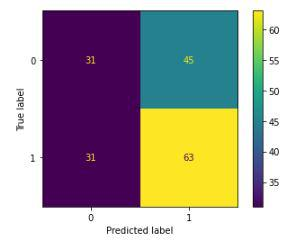

Conclusion:
We can observe that the accuracy achieved by the state-of-the-art ML model is no better than simply guessing with a probability of 50%. Possible reasons for this may be the lack of data or using a very simple model to perform such a complex task as Stock Market prediction.